# S&P 500 Stock Prices — Exploratory Data Analysis

This notebook performs comprehensive EDA on the S&P 500 price dataset (2015–2025), including missing-value handling, return computation, risk metrics, and visualizations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths (works from project root or notebook/ folder)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd if (_cwd / "data" / "Prices.csv").exists() else _cwd.parent
DATA_PATH = PROJECT_ROOT / "data" / "Prices.csv"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)
FIGS_DIR = OUTPUTS_DIR / "figs"
FIGS_DIR.mkdir(exist_ok=True)

# Style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

## 1. Load Data & Initial Inspection

Load `Prices.csv` (wide format: Date + ticker columns with adjusted close prices).

In [ ]:
df = pd.read_csv(DATA_PATH)
df.head()

,Date,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
0,2015-01-02,24.237549,15.4260,26.278944,76.955551,46.511124,77.905800,39.858452,0.483011,66.518349,57.916889
1,2015-01-05,23.554735,15.1095,25.778227,76.418083,45.067196,76.654541,39.491920,0.474853,66.202065,56.332203
2,2015-01-06,23.556952,14.7645,25.142035,76.042580,43.898651,75.621750,38.912289,0.460457,65.900513,56.032726
3,2015-01-07,23.887281,14.9210,25.068092,77.721291,43.965630,75.621750,39.406689,0.459257,66.246216,56.600468
4,2015-01-08,24.805077,15.0230,25.155436,78.332405,44.948116,77.637688,40.565952,0.476533,67.003761,57.542580


In [ ]:
# Parse Date as datetime, sort by date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Basic info
print("Shape:", df.shape)
print("Date range:", df["Date"].min(), "to", df["Date"].max())
print("\nTickers:", list(df.columns.drop("Date")))

Shape: (2765, 11)
Date range: 2015-01-02 00:00:00 to 2025-12-30 00:00:00

Tickers: ['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'META', 'MSFT', 'NVDA', 'PG', 'XOM']


## 2. Missing Values: Validation & Policy

**Validation:** Count missing values per column.

**Policy options:**
- **Drop:** Remove rows with any missing values. Simple but loses data; suitable if missingness is sparse and random.
- **Forward-fill (ffill):** Carry last valid price forward. Standard for equity prices where missingness often reflects non-trading days or delayed data. Preserves time-series continuity.

**Decision:** We use **forward-fill** because (1) price series are continuous; (2) we want to maximize usable history for backtests; (3) any remaining NaNs at the start (before first valid price) will be dropped.

In [ ]:
# Validate missing values
price_cols = [c for c in df.columns if c != "Date"]
missing = df[price_cols].isna().sum()
print("Missing values per ticker:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values.")
print("\nTotal missing:", df[price_cols].isna().sum().sum())

Missing values per ticker:
No missing values.

Total missing: 0


In [ ]:
# Implement policy: forward-fill prices, then drop any remaining NaNs (e.g. leading)
prices = df[price_cols].ffill().bfill()  # bfill for any leading NaNs
prices.insert(0, "Date", df["Date"])
df_clean = prices.dropna(how="any").reset_index(drop=True)

print("Rows before:", len(df), "| After:", len(df_clean))
df_clean.head()

Rows before: 2765 | After: 2765


,Date,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
0,2015-01-02,24.237549,15.4260,26.278944,76.955551,46.511124,77.905800,39.858452,0.483011,66.518349,57.916889
1,2015-01-05,23.554735,15.1095,25.778227,76.418083,45.067196,76.654541,39.491920,0.474853,66.202065,56.332203
2,2015-01-06,23.556952,14.7645,25.142035,76.042580,43.898651,75.621750,38.912289,0.460457,65.900513,56.032726
3,2015-01-07,23.887281,14.9210,25.068092,77.721291,43.965630,75.621750,39.406689,0.459257,66.246216,56.600468
4,2015-01-08,24.805077,15.0230,25.155436,78.332405,44.948116,77.637688,40.565952,0.476533,67.003761,57.542580


## 3. Returns

Convert prices to **simple returns** and **log returns**.

In [ ]:
# Simple returns: r_t = (P_t - P_{t-1}) / P_{t-1}
simple_returns = df_clean[price_cols].pct_change().dropna(how="all")

# Log returns: r_t = log(P_t / P_{t-1})
log_returns = np.log(df_clean[price_cols] / df_clean[price_cols].shift(1)).dropna(how="all")

# Align with dates (first row is NaN for returns)
ret_dates = df_clean["Date"].iloc[1:].reset_index(drop=True)
simple_returns = simple_returns.reset_index(drop=True)
simple_returns.insert(0, "Date", ret_dates)
log_returns = log_returns.reset_index(drop=True)
log_returns.insert(0, "Date", ret_dates)

# Primary returns for downstream analysis (use simple returns; log returns similar for small r)
returns = simple_returns.copy()
print("Returns shape:", returns.shape)
returns.head()

Returns shape: (2764, 11)


,Date,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
0,2015-01-05,-0.028172,-0.020517,-0.019054,-0.006984,-0.031045,-0.016061,-0.009196,-0.016890,-0.004755,-0.027361
1,2015-01-06,0.000094,-0.022833,-0.024679,-0.004914,-0.025929,-0.013473,-0.014677,-0.030318,-0.004555,-0.005316
2,2015-01-07,0.014023,0.010600,-0.002941,0.022076,0.001526,0.000000,0.012705,-0.002606,0.005246,0.010132
3,2015-01-08,0.038422,0.006836,0.003484,0.007863,0.022347,0.026658,0.029418,0.037617,0.011435,0.016645
4,2015-01-09,0.001073,-0.011749,-0.012211,-0.013629,-0.017387,-0.005628,-0.008405,0.004028,-0.009330,-0.001410


## 4. Per-Ticker Metrics

Compute for each ticker:
- **Annualized return** (from geometric mean of daily returns)
- **Annualized volatility** (daily std × √252)
- **Sharpe ratio** (assume risk-free rate = 0)
- **Maximum drawdown** (peak-to-trough decline in cumulative returns)

In [ ]:
TRADING_DAYS = 252

def annualized_return(r):
    """Geometric: (1+R_ann) = (1+r_1)*...*(1+r_T) -> R_ann = prod(1+r)^(252/T) - 1"""
    prod_gross = (1 + r).prod()
    T = r.dropna().count()
    return prod_gross ** (TRADING_DAYS / T) - 1 if T > 0 else np.nan

def annualized_vol(r):
    return r.std() * np.sqrt(TRADING_DAYS)

def sharpe_ratio(r, rf=0):
    ann_ret = annualized_return(r)
    ann_vol = annualized_vol(r)
    return (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan

def max_drawdown(r):
    cum = (1 + r).cumprod()
    rolling_max = cum.cummax()
    dd = (cum - rolling_max) / rolling_max
    return dd.min()

ret_only = returns[price_cols]
metrics = pd.DataFrame({
    "annualized_return": ret_only.apply(annualized_return),
    "annualized_volatility": ret_only.apply(annualized_vol),
    "sharpe_ratio": ret_only.apply(sharpe_ratio),
    "max_drawdown": ret_only.apply(max_drawdown),
})
metrics

,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
AAPL,0.247082,0.288506,0.856421,-0.385159
AMZN,0.280623,0.329333,0.852097,-0.561453
GOOGL,0.253727,0.288466,0.879572,-0.443201
JNJ,0.094365,0.182034,0.518394,-0.273663
JPM,0.192911,0.271535,0.710444,-0.436265
META,0.216076,0.375375,0.575627,-0.767361
MSFT,0.256446,0.268916,0.953631,-0.371485
NVDA,0.722096,0.487002,1.482738,-0.663351
PG,0.072988,0.185158,0.394193,-0.245042
XOM,0.069473,0.274216,0.253353,-0.613425


## 5. Visualizations (10+)

Each figure is displayed with `plt.show()` and saved to `outputs/figs/` as PNG.

1. **price_sample.png** — Price curves for 4–6 representative tickers  
2. **return_hist.png** — Return distributions (histogram/KDE)  
3. **rolling_vol.png** — Rolling volatility (21-day)  
4. **drawdown.png** — Drawdown plot  
5. **corr_heatmap.png** — Correlation heatmap  
6. **top_bottom_return.png** — Top/bottom by annualized return  
7. **sharpe_ratio.png** — Sharpe ratio by ticker  
8. **top_bottom_metrics.png** — Volatility and max drawdown  
9. **cum_returns.png** — Cumulative returns (normalized)  
10. **return_ts_aapl.png** — Daily returns time series (AAPL)  
11. **return_boxplot.png** — Box plot by ticker  
12. **risk_return_scatter.png** — Risk-return trade-off scatter

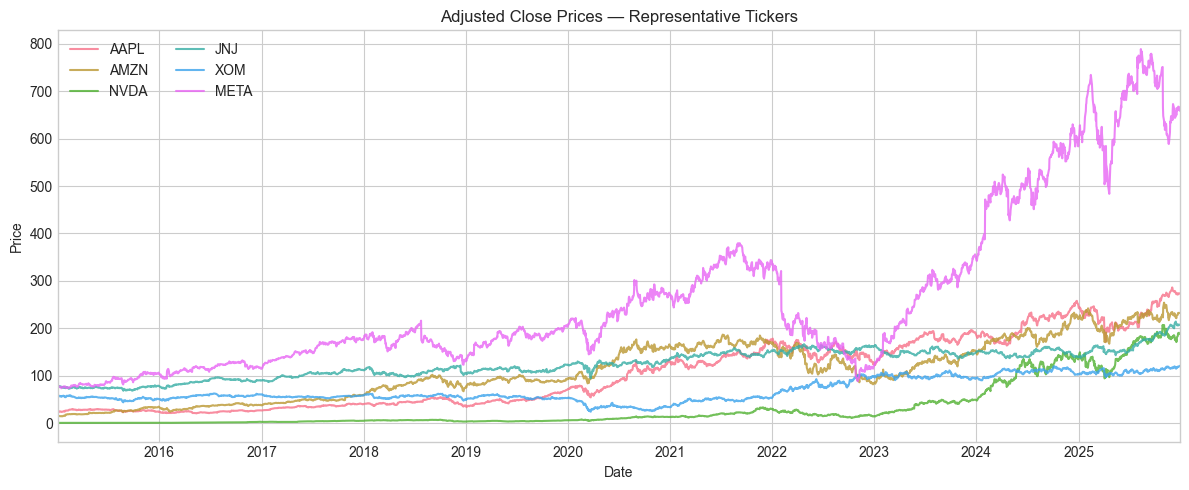

In [ ]:
# 1. Price curves for 4–6 representative tickers
REP_TICKERS = ["AAPL", "AMZN", "NVDA", "JNJ", "XOM", "META"]

fig, ax = plt.subplots(figsize=(12, 5))
for t in REP_TICKERS:
    if t in df_clean.columns:
        ax.plot(df_clean["Date"], df_clean[t], label=t, alpha=0.8)
ax.set_title("Adjusted Close Prices — Representative Tickers")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc="upper left", ncol=2)
ax.set_xlim(df_clean["Date"].min(), df_clean["Date"].max())
plt.tight_layout()
plt.savefig(FIGS_DIR / "price_sample.png", dpi=150, bbox_inches="tight")
plt.show()

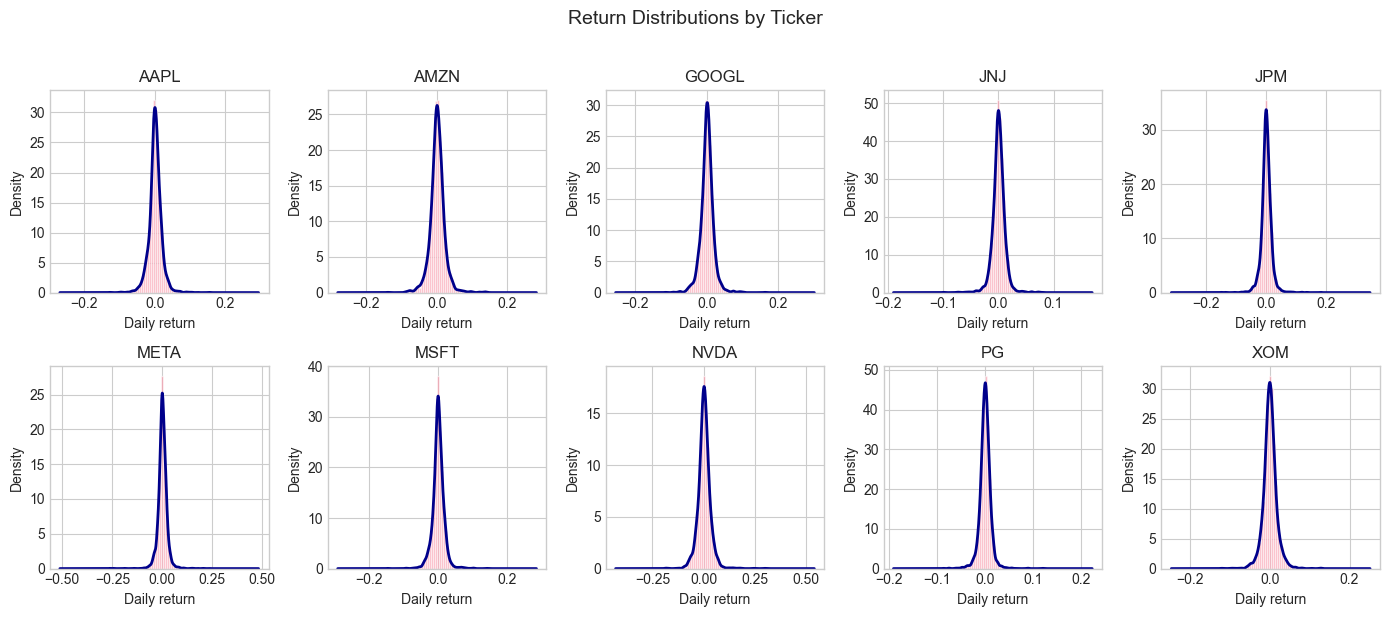

In [ ]:
# 2. Return distributions (KDE)
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()
for i, t in enumerate(price_cols):
    ret_only[t].dropna().hist(bins=50, ax=axes[i], density=True, alpha=0.6, edgecolor="white")
    ret_only[t].dropna().plot(kind="kde", ax=axes[i], color="darkblue", lw=2)
    axes[i].set_title(t)
    axes[i].set_xlabel("Daily return")
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
fig.suptitle("Return Distributions by Ticker", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGS_DIR / "return_hist.png", dpi=150, bbox_inches="tight")
plt.show()

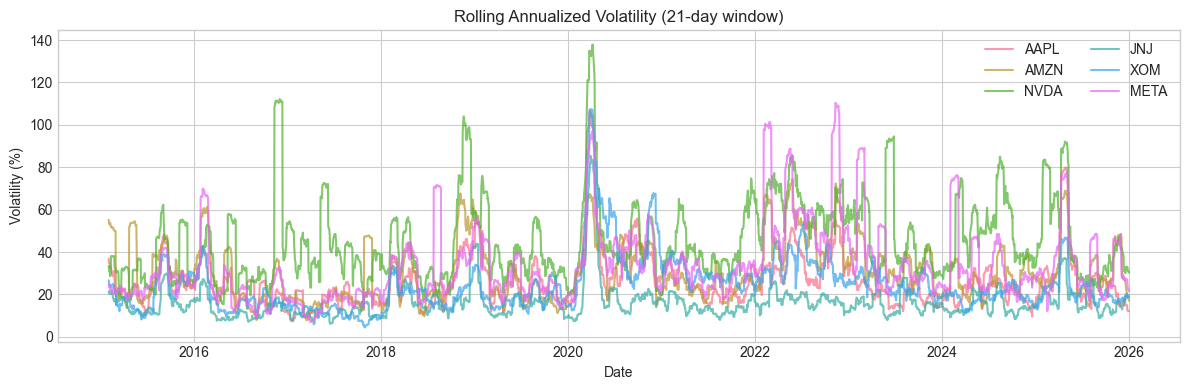

In [ ]:
# 3. Rolling volatility (21-day ≈ 1 month)
WINDOW = 21
roll_vol = ret_only.rolling(WINDOW).std() * np.sqrt(TRADING_DAYS) * 100  # annualized %

fig, ax = plt.subplots(figsize=(12, 4))
for t in REP_TICKERS:
    if t in roll_vol.columns:
        ax.plot(ret_dates, roll_vol[t], label=t, alpha=0.7)
ax.set_title(f"Rolling Annualized Volatility ({WINDOW}-day window)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.savefig(FIGS_DIR / "rolling_vol.png", dpi=150, bbox_inches="tight")
plt.show()

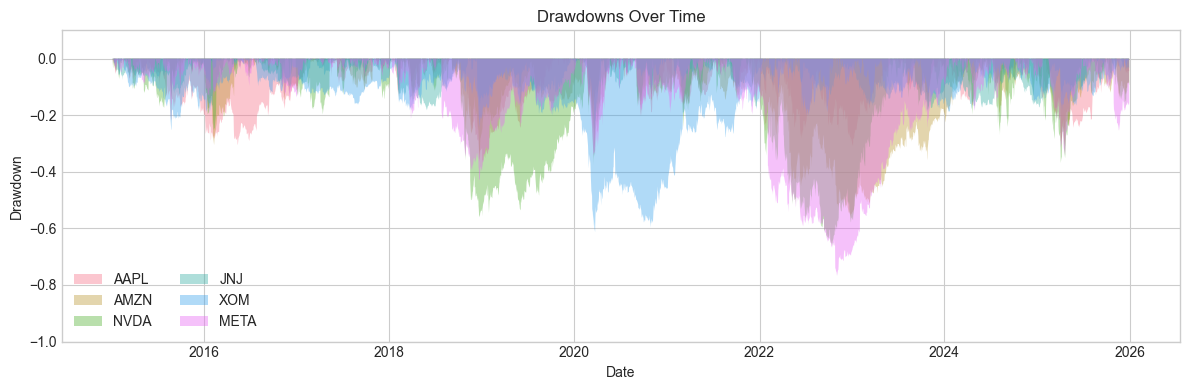

In [ ]:
# 4. Drawdown plot
cum = (1 + ret_only).cumprod()
rolling_max = cum.cummax()
drawdown = (cum - rolling_max) / rolling_max

fig, ax = plt.subplots(figsize=(12, 4))
for t in REP_TICKERS:
    if t in drawdown.columns:
        ax.fill_between(ret_dates, 0, drawdown[t], alpha=0.4, label=t)
ax.set_title("Drawdowns Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.legend(loc="lower left", ncol=2)
ax.set_ylim(-1, 0.1)
plt.tight_layout()
plt.savefig(FIGS_DIR / "drawdown.png", dpi=150, bbox_inches="tight")
plt.show()

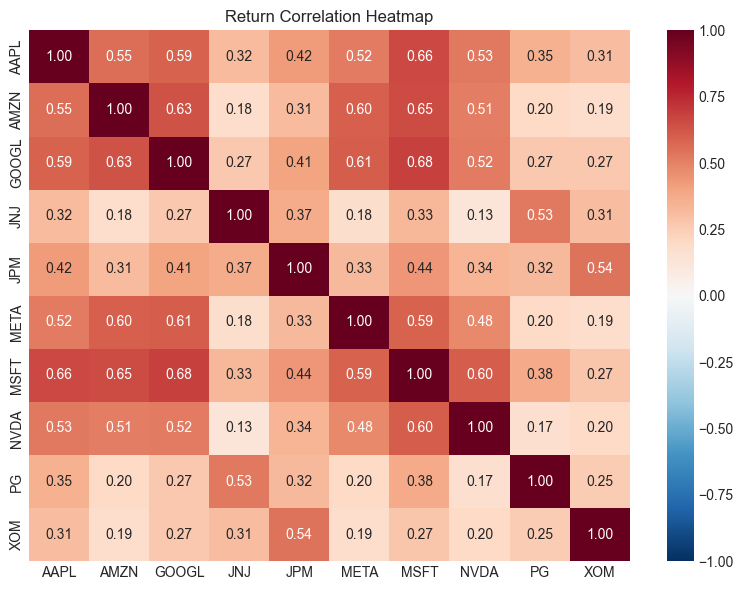

In [ ]:
# 5. Correlation heatmap
corr = ret_only.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title("Return Correlation Heatmap")
plt.tight_layout()
plt.savefig(FIGS_DIR / "corr_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

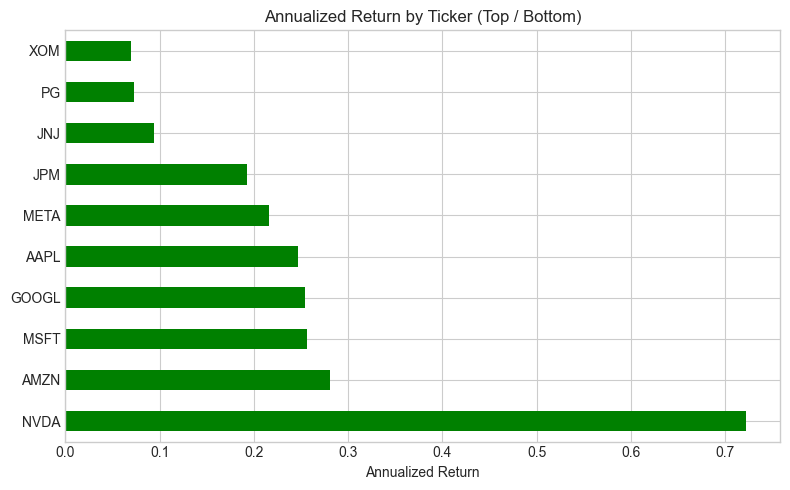

In [ ]:
# 6a. Top/bottom performers by annualized return
fig, ax = plt.subplots(figsize=(8, 5))
m = metrics.sort_values("annualized_return", ascending=False)
colors = ["green" if v >= 0 else "red" for v in m["annualized_return"]]
m["annualized_return"].plot(kind="barh", ax=ax, color=colors)
ax.axvline(0, color="black", lw=0.5)
ax.set_title("Annualized Return by Ticker (Top / Bottom)")
ax.set_xlabel("Annualized Return")
plt.tight_layout()
plt.savefig(FIGS_DIR / "top_bottom_return.png", dpi=150, bbox_inches="tight")
plt.show()

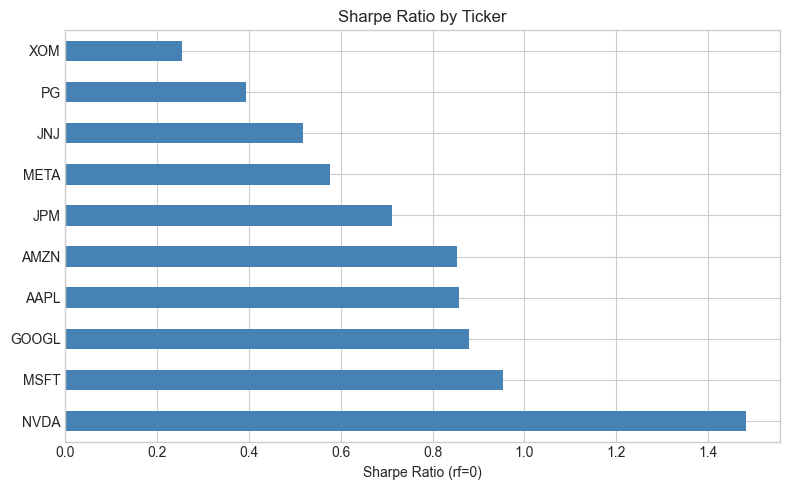

In [ ]:
# 6b. Top/bottom performers by Sharpe ratio
fig, ax = plt.subplots(figsize=(8, 5))
m = metrics.sort_values("sharpe_ratio", ascending=False)
m["sharpe_ratio"].plot(kind="barh", ax=ax, color="steelblue")
ax.axvline(0, color="black", lw=0.5)
ax.set_title("Sharpe Ratio by Ticker")
ax.set_xlabel("Sharpe Ratio (rf=0)")
plt.tight_layout()
plt.savefig(FIGS_DIR / "sharpe_ratio.png", dpi=150, bbox_inches="tight")
plt.show()

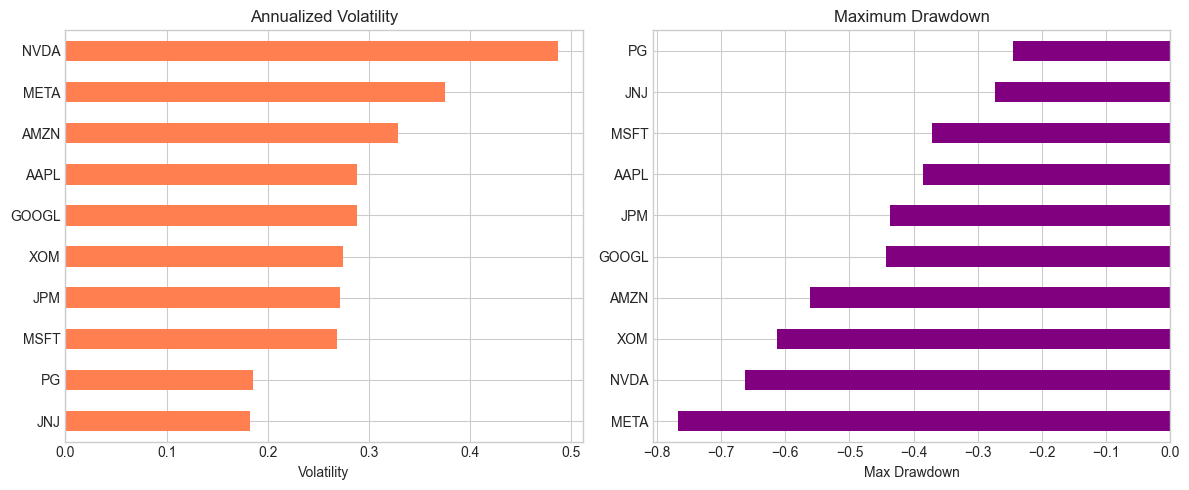

In [ ]:
# 6c. Volatility and max drawdown
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
metrics.sort_values("annualized_volatility")["annualized_volatility"].plot(kind="barh", ax=axes[0], color="coral")
axes[0].set_title("Annualized Volatility")
axes[0].set_xlabel("Volatility")
metrics.sort_values("max_drawdown")["max_drawdown"].plot(kind="barh", ax=axes[1], color="purple")
axes[1].set_title("Maximum Drawdown")
axes[1].set_xlabel("Max Drawdown")
plt.tight_layout()
plt.savefig(FIGS_DIR / "top_bottom_metrics.png", dpi=150, bbox_inches="tight")
plt.show()

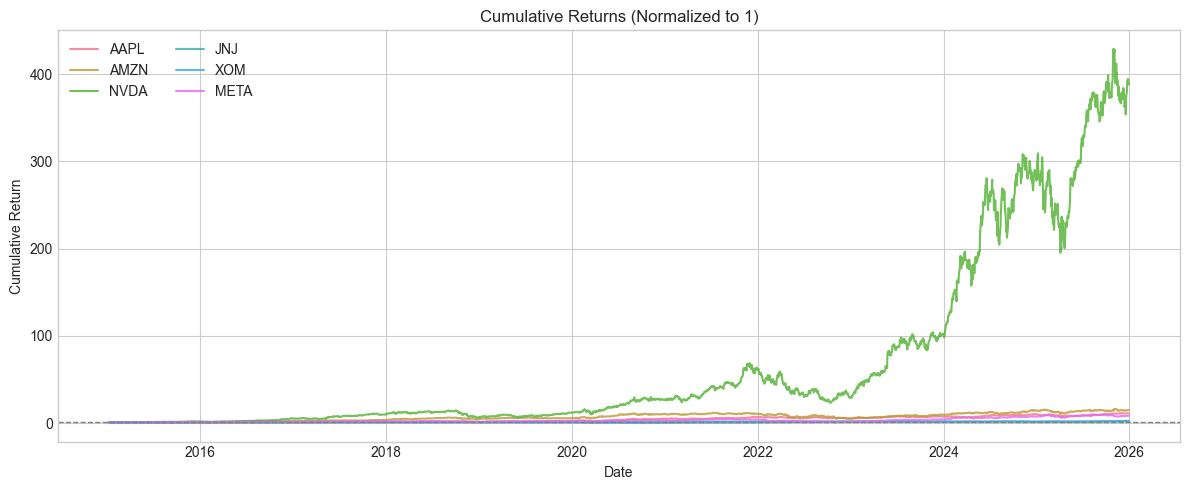

In [ ]:
# 7. Cumulative returns (normalized to 1)
fig, ax = plt.subplots(figsize=(12, 5))
for t in REP_TICKERS:
    if t in cum.columns:
        ax.plot(ret_dates, cum[t], label=t, alpha=0.8)
ax.set_title("Cumulative Returns (Normalized to 1)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.legend(loc="upper left", ncol=2)
ax.axhline(1, color="gray", ls="--", lw=1)
plt.tight_layout()
plt.savefig(FIGS_DIR / "cum_returns.png", dpi=150, bbox_inches="tight")
plt.show()

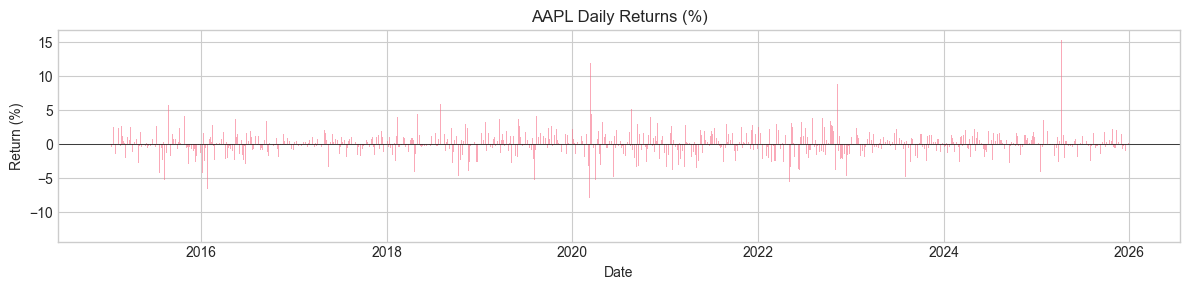

In [ ]:
# 8. Daily returns time series (sample: AAPL)
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(ret_dates, ret_only["AAPL"] * 100, width=1, alpha=0.6)
ax.axhline(0, color="black", lw=0.5)
ax.set_title("AAPL Daily Returns (%)")
ax.set_xlabel("Date")
ax.set_ylabel("Return (%)")
plt.tight_layout()
plt.savefig(FIGS_DIR / "return_ts_aapl.png", dpi=150, bbox_inches="tight")
plt.show()

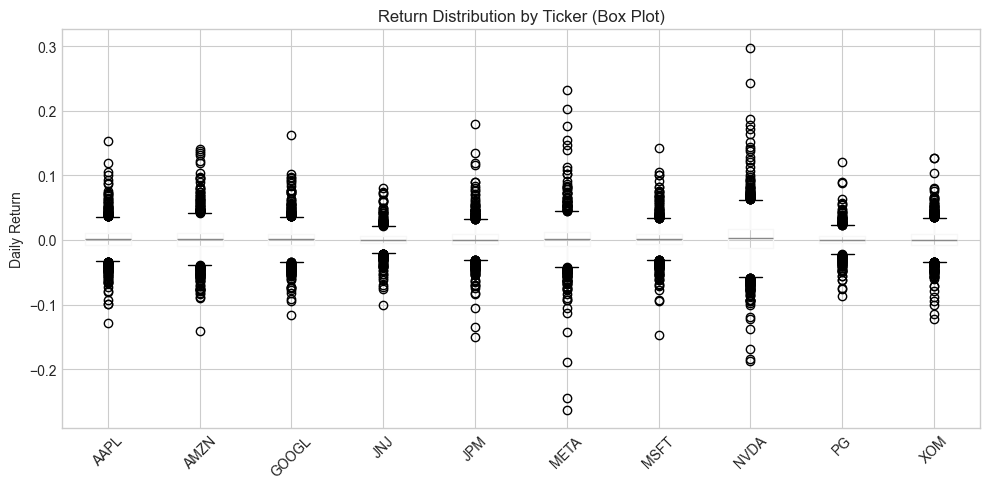

In [ ]:
# 9. Box plot of returns by ticker
fig, ax = plt.subplots(figsize=(10, 5))
ret_only[price_cols].boxplot(ax=ax)
ax.set_title("Return Distribution by Ticker (Box Plot)")
ax.set_ylabel("Daily Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGS_DIR / "return_boxplot.png", dpi=150, bbox_inches="tight")
plt.show()

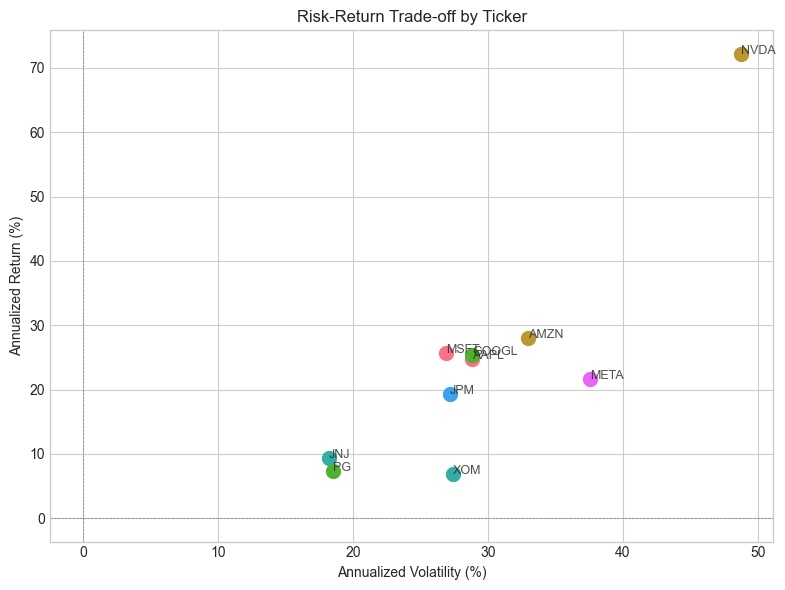

In [ ]:
# 10. Return vs Volatility scatter (risk-return trade-off)
fig, ax = plt.subplots(figsize=(8, 6))
for t in metrics.index:
    ax.scatter(metrics.loc[t, "annualized_volatility"] * 100,
               metrics.loc[t, "annualized_return"] * 100, s=100, label=t)
    ax.annotate(t, (metrics.loc[t, "annualized_volatility"] * 100,
                metrics.loc[t, "annualized_return"] * 100),
                fontsize=9, alpha=0.8)
ax.set_xlabel("Annualized Volatility (%)")
ax.set_ylabel("Annualized Return (%)")
ax.set_title("Risk-Return Trade-off by Ticker")
ax.axhline(0, color="gray", ls="--", lw=0.5)
ax.axvline(0, color="gray", ls="--", lw=0.5)
plt.tight_layout()
plt.savefig(FIGS_DIR / "risk_return_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Save Key Outputs to `outputs/`

Save returns, metrics, and correlation matrix for downstream use.

In [ ]:
# Save returns (include both simple and log if desired; here we save simple)
returns.to_csv(OUTPUTS_DIR / "returns.csv", index=False)
metrics.to_csv(OUTPUTS_DIR / "metrics.csv")
corr.to_csv(OUTPUTS_DIR / "corr.csv")

print("Saved CSV files:")
print("  - outputs/returns.csv")
print("  - outputs/metrics.csv")
print("  - outputs/corr.csv")
print("\nSaved figures (outputs/figs/):")
for f in sorted(FIGS_DIR.glob("*.png")):
    print("  -", f.relative_to(OUTPUTS_DIR))

Saved:
  - outputs/returns.csv
  - outputs/metrics.csv
  - outputs/corr.csv


## 7. Next-Step Advanced Analyses

Three concrete directions suitable for a finance portfolio project:

---

### 1. **Mean–Variance Portfolio Optimization (Markowitz)**

- Use `returns.csv` and `corr.csv` to compute the sample mean vector and covariance matrix.
- Solve for the **efficient frontier** (minimum-variance portfolios for a range of target returns).
- Implement **maximum Sharpe** and **minimum variance** portfolios.
- Compare out-of-sample performance with equal-weight and single-stock benchmarks.

---

### 2. **Risk Parity / Hierarchical Risk Parity (HRP)**

- Construct portfolios where each asset contributes equally to total risk (risk parity).
- Implement **Hierarchical Risk Parity** (López de Prado) using the correlation matrix and a hierarchical clustering + recursive bisection scheme.
- Backtest HRP vs. mean–variance and equal-weight on a rolling-window basis.

---

### 3. **Factor Decomposition & Regime Detection**

- Regress returns on common factors (e.g. market factor from equal-weight portfolio, or Fama–French factors if available).
- Analyze residual correlations and idiosynchratic risk.
- Use **Hidden Markov Models (HMM)** or **regime-switching models** to detect volatility regimes; condition portfolio weights on the estimated regime.